In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# print(np.__version__)


In [2]:
# import required packages
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.integrate import odeint

# import MAGI-X packages
from scripts.magix.dynamic import nnSTModule, nnMTModule # neural network module
from scripts.magix.inference import FMAGI # inferred module

In [6]:
# 2. Parameters & ground truth

def FN(y, t, a, b, c):
	V, R = y
	dVdt = c * (V - np.power(V,3)/3.0 + R)
	dRdt = -1./c * (V - a + b*R)
	return (dVdt,dRdt)

a, b, c = 0.2, 0.2, 3.0
y0_true = [-1.0, 1.0]

t_max = 40
n_points = 1281
noise_level = 0.1

t_grid = np.linspace(0, t_max, n_points)
x_clean = odeint(FN, [-1.0, 1.0], t_grid)
y_obs = np.column_stack((t_grid, x_clean))  # each row [t, V, R]

torch.set_default_dtype(torch.double)
# Build and run MAGI-X inference
# ys: list of tensors [n x 2] for each component: [time, value]
ys = []
for i in range(1, y_obs.shape[1]):
    data = torch.tensor(y_obs[:, [0, i]], dtype=torch.double)
    ys.append(data)

TypeError: FN() missing 3 required positional arguments: 'a', 'b', and 'c'

## npode

In [7]:
import sys
print(sys.executable)


/mnt/home/sykim/.conda/envs/py39/bin/python


In [11]:
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

# # configure the session to only use that one GPU
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# config.gpu_options.visible_device_list = "0"
# sess = tf.Session(config=config)
# import numpy as np

In [8]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

# Add path to NPODE code
sys.path.insert(0, '/mnt/home/sykim/MAGI-TS/old_experiment/scripts/npode')
# /home/gimlullu6/MAGI-TS-1/old_experiment/scripts/npode
from npde import NPODE  # Import the NPODE class

2025-04-29 18:30:34.355874: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 18:30:34.366402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745919034.378492  624027 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745919034.382126  624027 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745919034.393390  624027 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

hellooo
this is jitter0.1


In [9]:
# import required packages
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.integrate import odeint

# import MAGI-X packages
from scripts.magix.dynamic import nnSTModule, nnMTModule # neural network module
from scripts.magix.inference import FMAGI # inferred module


import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()

# configure the session to only use that one GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "0"
sess = tf.Session(config=config)

# ----- monkey-patch for tf.contrib.distributions -----
import tensorflow_probability as tfp
import types
tf.contrib = types.SimpleNamespace(
    distributions=types.SimpleNamespace(
        MultivariateNormalFullCovariance = tfp.distributions.MultivariateNormalFullCovariance,
        MultivariateNormalDiag           = tfp.distributions.MultivariateNormalDiag
    )
)

Instructions for updating:
non-resource variables are not supported in the long term


I0000 00:00:1745919039.796660  624027 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 42457 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6


In [10]:
import numpy as np
# import tensorflow as tf
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

from kernels import OperatorKernel
from npde_helper import build_model, fit_model
# tf.reset_default_graph()

def train_npode_model(states, derivs, t, sess,
                      inducing_points=100,
                      num_iter=500):
    """
    Fit the TF-based NPODE to 2D data.
    states:    (N,2) numpy array of (x,y) points
    derivs:    (N,2) numpy array of (dx/dt,dy/dt)
    t:         (N,)  numpy array of time-stamps
    inducing_points: total number M = inducing_points
    num_iter:  how many optimizer steps
    Returns: (sess, trained_model)
    """
    # 1) Grid of inducing locations Z0
    # x_min, x_max = states[:,0].min(), states[:,0].max()
    # y_min, y_max = states[:,1].min(), states[:,1].max()
    grid_size = int(np.sqrt(inducing_points))
    xs = np.linspace(0, 10, grid_size)
    ys = np.linspace(0, 10, grid_size)
    Xg, Yg = np.meshgrid(xs, ys)
    Z0 = np.vstack([Xg.ravel(), Yg.ravel()]).T   # shape (M,2)

    # 2) Initial U0 by linear interpolation of observed derivs
    U0 = griddata(states, derivs,
                  Z0,
                  method='linear',
                  fill_value=0.0)                # (M,2)

    # 3) Noise‐variance init
    sn0 = np.zeros(2)                         # one σ² per dimension

    # 4) GP kernel
    kern = OperatorKernel(sf0=1.0,
                          ell0=[1.0,1.0],
                          ktype="id")

    # 5) Build TensorFlow session and model
    # tf.reset_default_graph()
    # sess = tf.Session()

    npde = build_model(
        sess=sess,
        t=[t],
        Y=[states],
        model='ode',       # ODE case
        sf0=1.0,
        ell0=[1.0,1.0],
        W=grid_size,       # grid width per dim
        ktype="id",
        whiten=True,
        fix_ell=False,
        fix_sf=False,
        fix_Z=False,
        fix_U=False,
        fix_sn=False
    )

    # 6) Fit with MAGI-TS’s optimizer
    #    Returns the inferred initial x0 (unused here) and the model
    _, trained = fit_model(
        sess=sess,
        model=npde,
        t=[t],
        Y=[states],
        Nw=10,
        num_iter=num_iter,
        print_every=50,
        plot_=False
    )

    return sess, trained

def compute_vector_field(model, sess,
                         grid_size=20,
                         x_range=(0,10),
                         y_range=(0,10)):
    """
    On a regular grid, evaluate the learned GP derivative f.
    Returns dict with X,Y,U,V,magnitude.
    """
    xs = np.linspace(x_range[0], x_range[1], grid_size)
    ys = np.linspace(y_range[0], y_range[1], grid_size)
    X, Y = np.meshgrid(xs, ys)
    U = np.zeros_like(X)
    V = np.zeros_like(Y)

    for i in range(grid_size):
        for j in range(grid_size):
            pt = np.array([[X[i,j], Y[i,j]]])
            # run the TF graph to get f(pt)
            u_vec = sess.run(model.f(pt))  # shape (1,2)
            U[i,j], V[i,j] = u_vec[0,0], u_vec[0,1]

    mag = np.sqrt(U**2 + V**2)
    return {'X': X, 'Y': Y, 'U': U, 'V': V, 'magnitude': mag}

def plot_npode_vs_magix(true_vf, npode_vf, magix_vf):
    """
    Three‐panel quiver comparison.
    """
    fig, axes = plt.subplots(1,3,figsize=(18,6))
    for ax, vf, title in zip(axes,
                             (true_vf, npode_vf, magix_vf),
                             ('True VF','NPODE VF','MAGI-X VF')):
        q = ax.quiver(vf['X'], vf['Y'],
                      vf['U'], vf['V'],
                      vf['magnitude'],
                      scale_units='xy',
                      angles='xy',
                      scale=25, width=0.004)
        fig.colorbar(q, ax=ax)
        ax.set_title(title)
        ax.set_xlabel('x'); ax.set_ylabel('y')
        ax.set_xlim(true_vf['X'].min(), true_vf['X'].max())
        ax.set_ylim(true_vf['Y'].min(), true_vf['Y'].max())
        ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ──────────────────────────────────────────────────────────────
# Example usage:

# 1) Load or define your LV data:
#    `single_states`  shape (N,2), `single_derivs` shape (N,2), `t` shape (N,)
# 2) Compute true vector field by your existing `compute_true_vector_field` (unchanged)
# 3) Train:
# sess, npode_model = train_npode_model(
#     single_states, single_derivs, t,
#     inducing_points=400,   # e.g. 20×20 grid
#     num_iter=500
# )
#
# 4) Compute learned VF:
# npode_vf = compute_vector_field(npode_model, sess,
#                                 grid_size=20,
#                                 x_range=(0,10), y_range=(0,10))
#
# 5) Likewise compute `magix_vf` via your MAGI-X code, then:
# plot_npode_vs_magix(true_vf, npode_vf, magix_vf)


this is jitter in helper file0.1


In [11]:
# ─── Cell 2: Simulate Lotka–Volterra data ──────────────────────────────────

def FN_true(y, t, a=0.2, b=0.2, c=3.0):
    V, R = y
    dVdt = c * (V - V**3 / 3.0 + R)
    dRdt = -1.0 / c * (V - a + b * R)
    return np.array([dVdt, dRdt])

def simulate_fn(a=0.2, b=0.2, c=3.0,
                y0=(-1.0, 1.0), t_end=40, n_pts=201):
    """
    Simulate the FitzHugh–Nagumo system using FN_true.

    Args:
        a, b, c: parameters in FN_true
        y0:   tuple (V0, R0) initial conditions
        t_end: final time
        n_pts: number of time points

    Returns:
        t:  (n_pts,) time grid
        X:  (n_pts, 2) simulated [V, R]
        dX: (n_pts, 2) true derivatives at each (V,R)
    """
    # time grid
    t = np.linspace(0, t_end, n_pts)

    # integrate FN_true (which already uses a, b, c defaults)
    # to override those defaults, we wrap it in a lambda:
    X = odeint(lambda y, τ: FN_true(y, τ, a, b, c), y0, t)

    # stack true derivatives at each point
    dX = np.vstack([FN_true(xi, τi, a, b, c) for xi, τi in zip(X, t)])

    return t, X, dX

# run it
t, states, derivs = simulate_fn()
print("states shape:", states.shape, "derivs shape:", derivs.shape)


states shape: (201, 2) derivs shape: (201, 2)


In [14]:
# ─── Cell 3: True vector field ─────────────────────────────────────────────

import numpy as np

def compute_true_vector_field_fn(grid_size=20,
                                 v_range=(-2.5, 2.5),
                                 r_range=(-2.0, 2.0),
                                 a=0.2, b=0.2, c=3.0):
    """
    Compute the true vector field for the FitzHugh–Nagumo model.

    Args:
        grid_size: number of points per axis
        v_range:  tuple (v_min, v_max) range for V (membrane potential)
        r_range:  tuple (r_min, r_max) range for R (recovery variable)
        a, b, c:  parameters of FN_true

    Returns:
        dict with keys:
          'X', 'Y'       : meshgrid of V and R values
          'U', 'V'       : dV/dt and dR/dt at each grid point
          'magnitude'    : speed √(U² + V²)
    """
    # create a grid over (V, R)
    v = np.linspace(v_range[0], v_range[1], grid_size)
    r = np.linspace(r_range[0], r_range[1], grid_size)
    X, Y = np.meshgrid(v, r)

    # allocate arrays for the derivatives
    U = np.zeros_like(X)
    V = np.zeros_like(Y)

    # fill in the true derivatives at each grid point
    for i in range(grid_size):
        for j in range(grid_size):
            dVdt, dRdt = FN_true([X[i, j], Y[i, j]], 0, a, b, c)
            U[i, j] = dVdt
            V[i, j] = dRdt

    # compute vector magnitude for plotting
    magnitude = np.sqrt(U**2 + V**2)

    return {
        'X': X,
        'Y': Y,
        'U': U,
        'V': V,
        'magnitude': magnitude
    }

# Example usage:
true_vf = compute_true_vector_field_fn()



In [16]:
# ─── Cell 4: Train the TensorFlow NPODE ────────────────────────────────────
# Reset TF graph so repeated runs in notebook won't clash
# tf.reset_default_graph()

sess, npode_model = train_npode_model(
    states, derivs, t,
    sess,
    inducing_points=400,  # 20×20 grid
    num_iter=200
)


Model being initialized...


2025-04-29 18:31:29.628385: W tensorflow/c/c_api.cc:305] Operation '{name:'OperatorKernel_3/ell/Assign' id:3977 op device:{requested: '', assigned: ''} def:{{{node OperatorKernel_3/ell/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](OperatorKernel_3/ell, OperatorKernel_3/softplus_1/inverse/softplus_inverse/SelectV2_2)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Building loss function...
Adam optimizer being initialized...


2025-04-29 18:31:30.559427: W tensorflow/c/c_api.cc:305] Operation '{name:'NPDE_1/sn/Assign' id:4194 op device:{requested: '', assigned: ''} def:{{{node NPDE_1/sn/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](NPDE_1/sn, NPDE_1/softplus/inverse/softplus_inverse/SelectV2_2)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Optimization starts.
       iteration       objective
               1        1635.927
              50         972.008
             100         928.058
             150         886.070
             200         843.588
Optimization ends.


In [17]:
def compute_npode_vector_field(sess, npode_model,
                               grid_size=20,
                               x_range=(-2.5, 2.5),
                               y_range=(-2.0, 2.0)):
    xs = np.linspace(x_range[0], x_range[1], grid_size)
    ys = np.linspace(y_range[0], y_range[1], grid_size)
    X, Y = np.meshgrid(xs, ys)
    U = np.zeros_like(X)
    V = np.zeros_like(Y)

    for i in range(grid_size):
        for j in range(grid_size):
            pt = np.array([[X[i, j], Y[i, j]]], dtype=np.float64)
            # note: npode_model.f is a TF-tensor, so we sess.run it
            uv = sess.run(npode_model.f(pt))  # shape (1,2)
            U[i, j], V[i, j] = uv[0,0], uv[0,1]

    return {
      'X': X, 'Y': Y,
      'U': U, 'V': V,
      'magnitude': np.sqrt(U**2 + V**2)
    }
    
npode_vf = compute_npode_vector_field(
    sess,
    npode_model,
    grid_size=20,
    x_range=(-2.5, 2.5),  # really V
    y_range=(-2.0, 2.0),  # really R
)


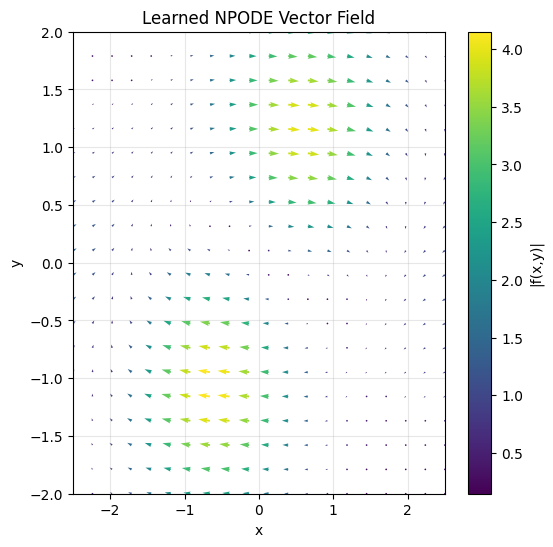

In [26]:
import matplotlib.pyplot as plt

# assume npode_vf is what you just computed
X, Y = npode_vf['X'], npode_vf['Y']
U, V = npode_vf['U'], npode_vf['V']
mag = npode_vf['magnitude']

plt.figure(figsize=(6,6))
Q = plt.quiver(
    X, Y, U, V, mag,
    scale_units='xy', angles='xy',
    scale=25, width=0.005
)
plt.colorbar(Q, label='|f(x,y)|')
plt.title("Learned NPODE Vector Field")
plt.xlabel("x"); plt.ylabel("y")
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.grid(alpha=0.3)
plt.show()


In [19]:
def plot_npode_vs_magix(true_vf, npode_vf, magix_vf, filename="npode_vs_magix_comparison.png"):
    """
    Create a comparison plot between NPODE and MAGI-X
    
    Args:
        true_vf: True vector field
        npode_vf: NPODE vector field
        magix_vf: MAGI-X vector field
        filename: Output file name
    """
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Calculate true nullclines for LV model
    # X-nullcline: Y = a/b
    # Y-nullcline: X = d/c
    
    # Plot true vector field
    q0 = axes[0].quiver(true_vf['X'], true_vf['Y'], true_vf['U'], true_vf['V'], 
                       true_vf['magnitude'], cmap=plt.cm.viridis, 
                       scale_units='xy', angles='xy', scale=25, width=0.004)
    fig.colorbar(q0, ax=axes[0], label='Magnitude')
    axes[0].axhline(y=a/b, color='r', linestyle='-', linewidth=1.5, label='X-nullcline')
    axes[0].axvline(x=d/c, color='g', linestyle='-', linewidth=1.5, label='Y-nullcline')
    axes[0].set_title('True Vector Field')
    axes[0].legend(loc='upper right')
    
    # Plot NPODE vector field
    q1 = axes[1].quiver(npode_vf['X'], npode_vf['Y'], npode_vf['U'], npode_vf['V'], 
                       npode_vf['magnitude'], cmap=plt.cm.viridis, 
                       scale_units='xy', angles='xy', scale=25, width=0.004)
    fig.colorbar(q1, ax=axes[1], label='Magnitude')
    
    # Plot true nullclines with dashed lines for reference
    axes[1].axhline(y=a/b, color='r', linestyle='--', linewidth=1.0, alpha=0.5)
    axes[1].axvline(x=d/c, color='g', linestyle='--', linewidth=1.0, alpha=0.5)
    
    # Add NPODE-estimated nullclines (would need higher resolution)
    # This would be similar to compute_estimated_nullclines but for NPODE
    
    axes[1].set_title('NPODE Vector Field')
    
    # Plot MAGI-X vector field
    q2 = axes[2].quiver(magix_vf['X'], magix_vf['Y'], magix_vf['U'], magix_vf['V'], 
                       magix_vf['magnitude'], cmap=plt.cm.viridis, 
                       scale_units='xy', angles='xy', scale=25, width=0.004)
    fig.colorbar(q2, ax=axes[2], label='Magnitude')
    
    # Plot true nullclines with dashed lines for reference
    axes[2].axhline(y=a/b, color='r', linestyle='--', linewidth=1.0, alpha=0.5)
    axes[2].axvline(x=d/c, color='g', linestyle='--', linewidth=1.0, alpha=0.5)
    
    axes[2].set_title('MAGI-X Vector Field')
    
    # Set common properties
    for ax in axes:
        ax.set_xlabel('X (Prey)')
        ax.set_ylabel('Y (Predator)')
        ax.set_xlim([-2.5, 2.5])
        ax.set_ylim([-2.0, 2.0])
        ax.grid(True, alpha=0.3)
    
    # Set title
    fig.suptitle('Lotka-Volterra: NPODE vs MAGI-X Comparison', fontsize=16)
    
    # Save figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

In [22]:
def FN_true(y, t, a=0.2, b=0.2, c=3.0):
    V, R = y
    dVdt = c * (V - V**3 / 3.0 + R)
    dRdt = -1.0 / c * (V - a + b * R)
    return np.array([dVdt, dRdt])

# ----------------------
# Generate noisy observations
# ----------------------
t_max = 40
n_points = 1281
noise_level = 0.1

t_grid = np.linspace(0, t_max, n_points)
x_clean = odeint(FN_true, [-1.0, 1.0], t_grid)
y_obs = np.column_stack((t_grid, x_clean))  # each row [t, V, R]

torch.set_default_dtype(torch.double)
# Build and run MAGI-X inference
# ys: list of tensors [n x 2] for each component: [time, value]
ys = []
for i in range(1, y_obs.shape[1]):
    data = torch.tensor(y_obs[:, [0, i]], dtype=torch.double)
    ys.append(data)

dim = 2
hidden_layers = [512]
# Initialize neural ODE model
dynamic_model = nnMTModule(dim, hidden_layers)

print("Before MAGI-X:", next(dynamic_model.parameters())[0,0].item())
# Run MAGI-X via FMAGI
magi = FMAGI(ys, dynamic_model, grid_size=201, interpolation_orders=3)
# Infer latent states and train the ODE network
t_grid_inf, x_inferred = magi.map(max_epoch=2500, learning_rate=1e-3,
                                  decay_learning_rate=True,
                                  hyperparams_update=False,
                                  dynamic_standardization=True,
                                  verbose=True, returnX=True)
# The network weights in dynamic_model are now updated by MAGI-X
print("After MAGI-X: ", next(dynamic_model.parameters())[0,0].item())



def compute_vector_field(model, grid_size=20, x_range=(0, 10), y_range=(0, 10)):
    """Compute the vector field for a neural network model"""
    x = np.linspace(x_range[0], x_range[1], grid_size)
    y = np.linspace(y_range[0], y_range[1], grid_size)
    X, Y = np.meshgrid(x, y)
    U, V = np.zeros_like(X), np.zeros_like(Y)
    for i in range(grid_size):
        for j in range(grid_size):
            state = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float64)
            with torch.no_grad():
                d = model(state).numpy()
            U[i, j], V[i, j] = d[0, 0], d[0, 1]
    return {'X': X, 'Y': Y, 'U': U, 'V': V, 'magnitude': np.sqrt(U**2 + V**2)}

single_vf = compute_vector_field(dynamic_model)

# plot_npode_vs_magix(
#     true_vf,
#     npode_vf,
#     single_vf,
#     filename="npode_vs_magix_single_comparison.png"
# )


Before MAGI-X: -0.45918148153980753
1/2500 iteration: 7.178788
500/2500 iteration: 2.829581
1000/2500 iteration: 2.256304
1500/2500 iteration: 1.952042
2000/2500 iteration: 1.742337
2500/2500 iteration: 1.584391
After MAGI-X:  -0.4484534289003686


In [23]:
# 6. Evaluate vector fields and nullclines

def compute_npode_vector_field(sess, npode_model,
                               grid_size=20,
                               x_range=(-2.5,2.5), y_range=(-2.0,2.0)):
    xs = np.linspace(*x_range, grid_size)
    ys = np.linspace(*y_range, grid_size)
    X, Y = np.meshgrid(xs, ys)
    U = np.zeros_like(X)
    V = np.zeros_like(Y)
    for i in range(grid_size):
        for j in range(grid_size):
            pt = np.array([[X[i, j], Y[i, j]]], dtype=np.float64)
            uv = sess.run(npode_model.f(pt))  # (1,2)
            U[i,j], V[i,j] = uv[0,0], uv[0,1]
    return {'X':X,'Y':Y,'U':U,'V':V}

def compute_npode_nullclines(sess, npode_model,
                             resolution=200,
                             x_range=(-2.5,2.5), y_range=(-2.0,2.0)):
    xs = np.linspace(*x_range, resolution)
    ys = np.linspace(*y_range, resolution)
    X, Y = np.meshgrid(xs, ys)
    U = np.zeros_like(X)
    V = np.zeros_like(Y)
    for i in range(resolution):
        for j in range(resolution):
            pt = np.array([[X[i, j], Y[i, j]]], dtype=np.float64)
            uv = sess.run(npode_model.f(pt))
            U[i,j], V[i,j] = uv[0,0], uv[0,1]
    return {'X':X,'Y':Y,'U':U,'V':V}


def compute_true_vector_field(grid_size=20, x_range=(-2.5,2.5), y_range=(-2.0,2.0)):
    x = np.linspace(*x_range, grid_size)
    y = np.linspace(*y_range, grid_size)
    X, Y = np.meshgrid(x, y)
    U = np.zeros_like(X)
    V = np.zeros_like(Y)
    for i in range(grid_size):
        for j in range(grid_size):
            dx = FN_true([X[i,j], Y[i,j]], 0)
            U[i,j], V[i,j] = dx
    return X, Y, U, V

def compute_estimated_vector_field(model, grid_size=20,
                                    x_range=(-2.5,2.5), y_range=(-2.0,2.0)):
    x = np.linspace(*x_range, grid_size)
    y = np.linspace(*y_range, grid_size)
    X, Y = np.meshgrid(x, y)
    U = np.zeros_like(X)
    V = np.zeros_like(Y)
    for i in range(grid_size):
        for j in range(grid_size):
            inp = torch.tensor([X[i,j], Y[i,j]], dtype=torch.double)
            with torch.no_grad():
                dx = model(inp).numpy().ravel()
            U[i,j], V[i,j] = dx
    return X, Y, U, V

def compute_estimated_nullclines(model, resolution=200,
                                  x_range=(-2.5,2.5), y_range=(-2.0,2.0)):
    x = np.linspace(*x_range, resolution)
    y = np.linspace(*y_range, resolution)
    X, Y = np.meshgrid(x, y)
    U = np.zeros_like(X)
    V = np.zeros_like(Y)
    for i in range(resolution):
        for j in range(resolution):
            inp = torch.tensor([X[i,j], Y[i,j]], dtype=torch.double)
            with torch.no_grad():
                dx = model(inp).numpy().ravel()
            U[i,j], V[i,j] = dx
    return {'X': X, 'Y': Y, 'U': U, 'V': V}

# Analytical nullclines for FitzHugh–Nagumo
def true_nullclines(x_null):
    y_null1 = x_null**3 / 3 - x_null
    y_null2 = (0.2 - x_null) / 0.2
    return y_null1, y_null2


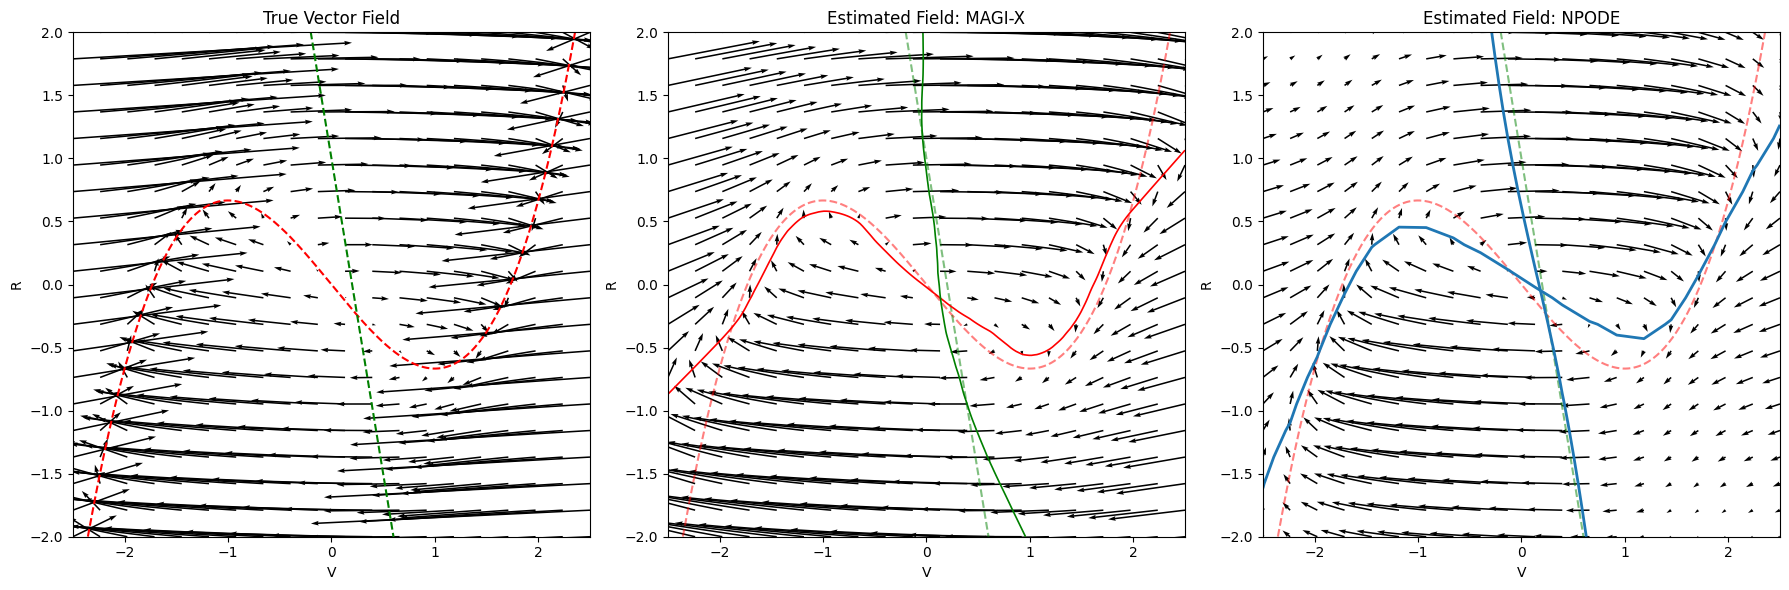

In [37]:
def plot_three_vector_fields(
    dynamic_model1,              # your MAGI-X / torch model
    npode_session,               # tf.Session
    npode_vf,                 # NPODE instance
    x_range=(-2.5, 2.5),
    y_range=(-2.0, 2.0),
    grid_size=20,
    nullcline_resolution=200,
    nullcline_points=400,
    true_cmap='viridis',
    est_cmap='plasma',
    true_scale=25,
    est_scale=25,
    figsize=(18, 6),
    filename=None
):
    # 1) true field
    X0, Y0, U0, V0 = compute_true_vector_field(grid_size, x_range, y_range)

    # 2) torch‐model field + nullclines
    X1, Y1, U1, V1 = compute_estimated_vector_field(dynamic_model1, grid_size, x_range, y_range)
    nulls1 = compute_estimated_nullclines(dynamic_model1, nullcline_resolution, x_range, y_range)

    # 3) npode‐model field + nullclines
    # t_est2 = compute_npode_vector_field(npode_session, npode_model, grid_size, x_range, y_range)
    # nulls2 = compute_npode_nullclines(npode_session, npode_model, nullcline_resolution, x_range, y_range)
    # Do this:
    X2 = npode_vf['X']
    Y2 = npode_vf['Y']
    U2 = npode_vf['U']
    V2 = npode_vf['V']
    M2 = npode_vf['magnitude']  # if you need it for coloring or scaling

    # analytical nullclines
    x_nc = np.linspace(*x_range, nullcline_points)
    y_nc1, y_nc2 = true_nullclines(x_nc)

    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # --- panel 1: true ---
    axes[0].quiver(X0, Y0, U0, V0, cmap=true_cmap, scale=true_scale)
    axes[0].plot(x_nc, y_nc1, 'r--')
    axes[0].plot(x_nc, y_nc2, 'g--')
    axes[0].set_title('True Vector Field')
    axes[0].set(xlabel='V', ylabel='R', xlim=x_range, ylim=y_range)

    # --- panel 2: torch model ---
    # X1, Y1, U1, V1 = t_est1.values()
    axes[1].quiver(X1, Y1, U1, V1, cmap=est_cmap, scale=est_scale)
    axes[1].plot(x_nc, y_nc1, 'r--', alpha=0.5)
    axes[1].plot(x_nc, y_nc2, 'g--', alpha=0.5)
    axes[1].contour(nulls1['X'], nulls1['Y'], nulls1['U'], [0], colors='r', linewidths=1.2)
    axes[1].contour(nulls1['X'], nulls1['Y'], nulls1['V'], [0], colors='g', linewidths=1.2)
    axes[1].set_title('Estimated Field: MAGI-X')
    axes[1].set(xlabel='V', ylabel='R', xlim=x_range, ylim=y_range)

    # --- panel 3: npode model ---
    # X2, Y2, U2, V2 = t_est2
    
    # npode_vf = compute_npode_vector_field(
    # sess,
    # npode_model,
    # grid_size=20,
    # x_range=(-2.5, 2.5),  # really V
    # y_range=(-2.0, 2.0),  # really R
    # )
    axes[2].quiver(X2, Y2, U2, V2, cmap=est_cmap, scale=est_scale)
    axes[2].plot(x_nc, y_nc1, 'r--', alpha=0.5)
    axes[2].plot(x_nc, y_nc2, 'g--', alpha=0.5)
    # axes[2].contour(nulls2['X'], nulls2['Y'], nulls2['U'], [0], colors='r', linewidths=1.2)
    # axes[2].contour(nulls2['X'], nulls2['Y'], nulls2['V'], [0], colors='g', linewidths=1.2)
    axes[2].contour(X2, Y2, U2, levels=[0], colors='C0', linewidths=2)
    axes[2].contour(X2, Y2, V2, levels=[0], colors='C0', linewidths=2)

    axes[2].set_title('Estimated Field: NPODE')
    axes[2].set(xlabel='V', ylabel='R', xlim=x_range, ylim=y_range)

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()


plot_three_vector_fields(dynamic_model, sess, npode_vf, filename='comparison.png')


## Attempt 2



In [24]:
# ─── Cell 2: Simulate log-LV trajectories ──────────────────────────────────
a, b, c, d = 1.5, 1.0, 1.0, 3.0

def LV(x, t, a, b, c, d):
    """Original LV in (P,D)-space dP/dt, dD/dt"""
    return [a*x[0] - b*x[0]*x[1],
            c*x[0]*x[1] - d*x[1]]

def get_log_lv_data(starts, t_max=12, n_steps=1000):
    """Return arrays U=(u,v) and dU=(du,dv) for each start, stacked."""
    all_uv = []
    all_duv = []
    tgrid = np.linspace(0, t_max, n_steps)
    for P0, D0 in starts:
        traj = odeint(LV, [P0, D0], tgrid, args=(a,b,c,d))
        uv    = np.log(traj)                              # (n_steps,2)
        deriv = np.vstack([LV(pt,ti,a,b,c,d) 
                           for pt,ti in zip(traj,tgrid)])  # (n_steps,2)
        duv   = deriv / traj                              # elementwise
        all_uv .append(uv)
        all_duv.append(duv)
    U  = np.concatenate(all_uv, axis=0)   # (M,2)
    dU = np.concatenate(all_duv,axis=0)   # (M,2)
    return U, dU

# choose single-start vs multi-start
single_start = [(5.0,0.2)]
multi_start  = [(5.0,0.2),(1.0,3.0),(3.0,1.0),(8.0,0.5),(0.5,0.5)]

U_single, dU_single = get_log_lv_data(single_start)
U_multi,  dU_multi  = get_log_lv_data(multi_start)

print("Single:", U_single.shape, dU_single.shape)
print("Multi: ", U_multi.shape,  dU_multi.shape)


Single: (1000, 2) (1000, 2)
Multi:  (5000, 2) (5000, 2)


In [25]:
# ─── Cell 3: Build & train the TF-NPODE on log-data ────────────────────────
from kernels import OperatorKernel
from npde_helper import build_model, fit_model

def train_npode_log(U, dU, t_max=12,
                    inducing_points=400,
                    num_iter=500):
    """
    Train TF NPODE on (u,v)->(du,dv) data.
    U:   (M,2) array of log-states
    dU:  (M,2) array of log-derivatives
    """
    # 1) build grid of inducing inputs in log-space
    u_min, u_max = U[:,0].min(), U[:,0].max()
    v_min, v_max = U[:,1].min(), U[:,1].max()
    G = int(np.sqrt(inducing_points))
    us = np.linspace(u_min, u_max, G)
    vs = np.linspace(v_min, v_max, G)
    Ug, Vg = np.meshgrid(us, vs)
    Z0 = np.vstack([Ug.ravel(), Vg.ravel()]).T

    # 2) init U0 by linear interp of your stacked dU
    from scipy.interpolate import griddata
    U0 = griddata(U, dU, Z0, method='linear', fill_value=0.0)

    # 3) noise-variance init (per dim)
    sn0 = np.zeros(2)

    # 4) a simple id-kernel in 2D
    kern = OperatorKernel(sf0=1.0, ell0=[1.,1.], ktype="id")

    # 5) TensorFlow graph & session
    # tf.reset_default_graph()
    sess = tf.Session()

    # build_model uses your npde_helper.build_model (TF1.x)
    npde = build_model(
        sess=sess,
        t=[np.linspace(0, t_max, U.shape[0])],  # dummy time grid
        Y=[U],               # but we're really fitting derivatives...
        model='ode',
        sf0=1.0,
        ell0=[1.0,1.0],
        W=G,
        ktype="id",
        whiten=True
    )

    # fit_model then optimizes the latent trajectory & kernel to match dU
    # note Y here is the log-states U; the NPODE objective uses the GP derivative to match dU
    _, trained = fit_model(
        sess=sess,
        model=npde,
        t=[np.linspace(0, t_max, U.shape[0])],
        Y=[U],
        Nw=10,
        num_iter=num_iter,
        plot_=False
    )

    return sess, trained

# train on single & multi
sess_s, npode_s = train_npode_log(U_single, dU_single, inducing_points=400, num_iter=500)
sess_m, npode_m = train_npode_log(U_multi,  dU_multi,   inducing_points=400, num_iter=500)


Model being initialized...


I0000 00:00:1745645681.967732   27757 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46866 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6


2025-04-26 14:34:42.919574: W tensorflow/c/c_api.cc:305] Operation '{name:'OperatorKernel_3/ell/Assign' id:55577 op device:{requested: '', assigned: ''} def:{{{node OperatorKernel_3/ell/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](OperatorKernel_3/ell, OperatorKernel_3/softplus_1/inverse/softplus_inverse/SelectV2_2)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Building loss function...
Adam optimizer being initialized...


2025-04-26 14:34:44.906192: W tensorflow/c/c_api.cc:305] Operation '{name:'NPDE_1/sn/Assign' id:55794 op device:{requested: '', assigned: ''} def:{{{node NPDE_1/sn/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](NPDE_1/sn, NPDE_1/softplus/inverse/softplus_inverse/SelectV2_2)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Optimization starts.
       iteration       objective
               1        4514.009
              10        2040.957


/mnt/home/sykim/MAGI-TS/old_experiment/scripts/npode/npde_helper.py:109: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if model is 'ode':
/mnt/home/sykim/MAGI-TS/old_experiment/scripts/npode/npde_helper.py:114: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif model is 'sde':
/mnt/home/sykim/MAGI-TS/old_experiment/scripts/npode/npde_helper.py:148: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if model.name is 'npode':
/mnt/home/sykim/MAGI-TS/old_experiment/scripts/npode/npde_helper.py:159: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif model.name is 'npsde':
/mnt/home/sykim/MAGI-TS/old_experiment/scripts/npode/npde_helper.py:216: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if model.name is 'npode':
/mnt/home/sykim/MAGI-TS/old_experiment/scripts/npode/npde_helper.py:109: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if model is 'ode':
/mnt/home/sykim/MAGI-TS/old_experiment/scripts/npode/npde_helper.py:114: SyntaxWa

KeyboardInterrupt: 